# Loading Libraries

In [13]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, Invertd, SaveImaged
from monai.data import decollate_batch
from src.utils import Config
from src.data_preparation import DataHandling, LoaderFactory
from src.vis import visualize_axial_slice, visualize_coronal_slice, model_visualize_coronal
from src.model_manager import ModelLoader


## Loading json file

In [2]:
config_file = 'src/config.json'
config = Config(config_file)

Requested device: cuda:0
CUDA is not available. Switching to CPU.


## Loading Test set

In [8]:
data_handler = DataHandling(
    config.ga_data_dir,
    train_mode=config.train_mode,
    target_mode=config.target_mode,
    external_centers=config.external_centers,
    train_percent=config.train_percent,
    val_percent=config.val_percent,
    test_percent=config.test_percent
    )


train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')


loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size=config.patch_size,
    spacing=config.spacing,
    spatial_size=config.spatial_size,
    normalize=config.normalize
    )


# Get the DataLoader for each dataset type
test_loader = loader_factory.get_loader('test', batch_size=config.batch_size['test'], num_workers=config.num_workers['test'], shuffle=False)
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]


Data from external center C5 has been moved to the test set.
Number of training files: 135
Number of validation files: 16
Number of test files: 31


## Visualizing input and target image

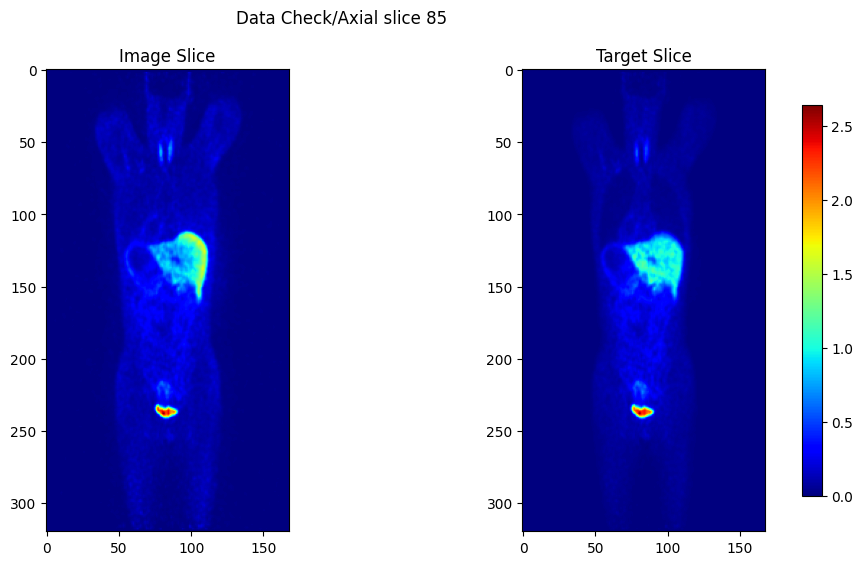

In [4]:
slice_index = 85  # Example slice index. Anyrhing between 75 to 100 is good.

# Visualizing from coronal view
visualize_coronal_slice(test_loader, slice_index)


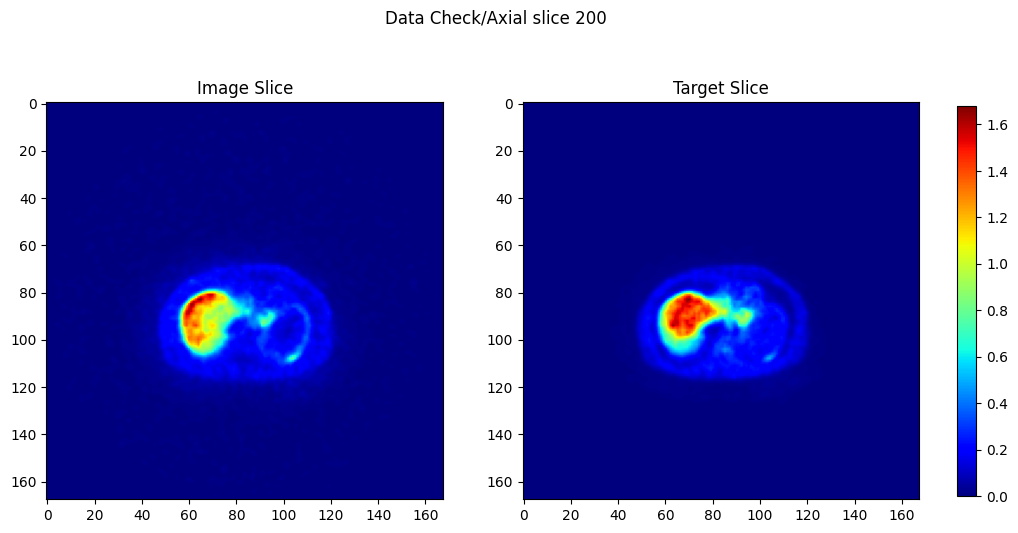

In [5]:
slice_index = 200  # Example slice index. pick around 150 to 300

# Visualizing from axial view
visualize_axial_slice(test_loader, slice_index)



## Loading Model

In [6]:
# Searching for model.
model_path =  'Results/model_4_24_23_17.pth'
model_loader = ModelLoader(config)
model = model_loader.call_model()

Starting a dynunet model training.


In [7]:
# Loading model in eval mode.
if os.path.exists(model_path):
    print(f"Model in {model_path} is loaded.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model in {model_path} not found.")

Model in Results/model_4_24_23_17.pth is loading.


# Evaluating Model, Generating DL image.

100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


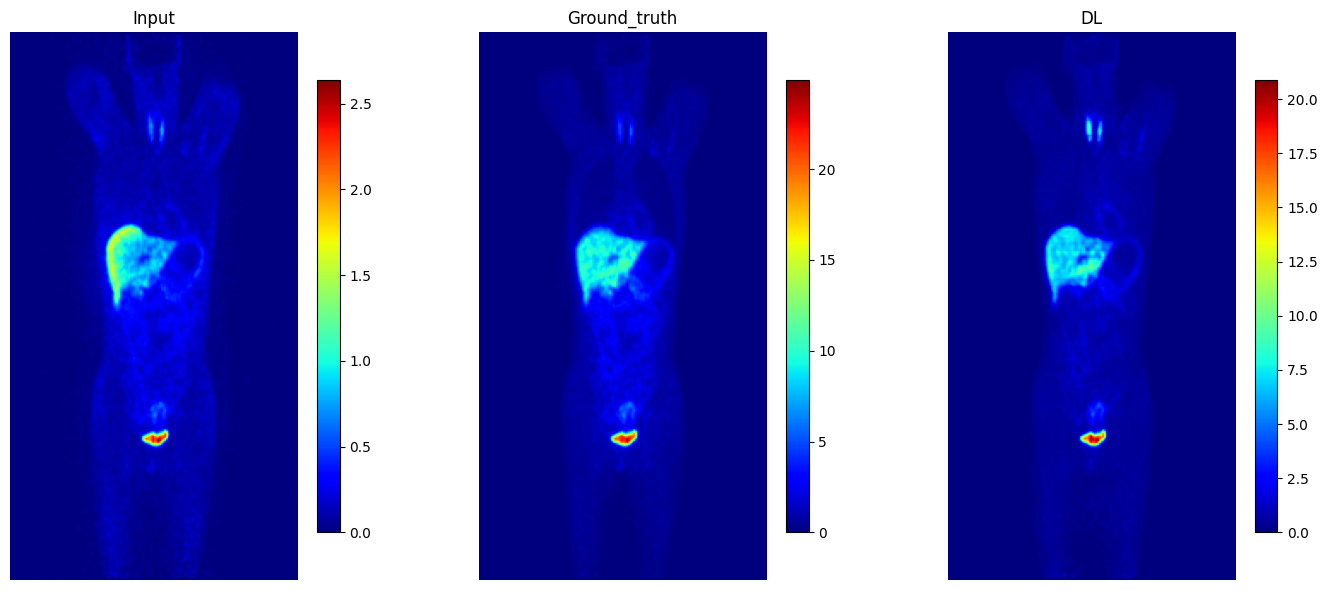

100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


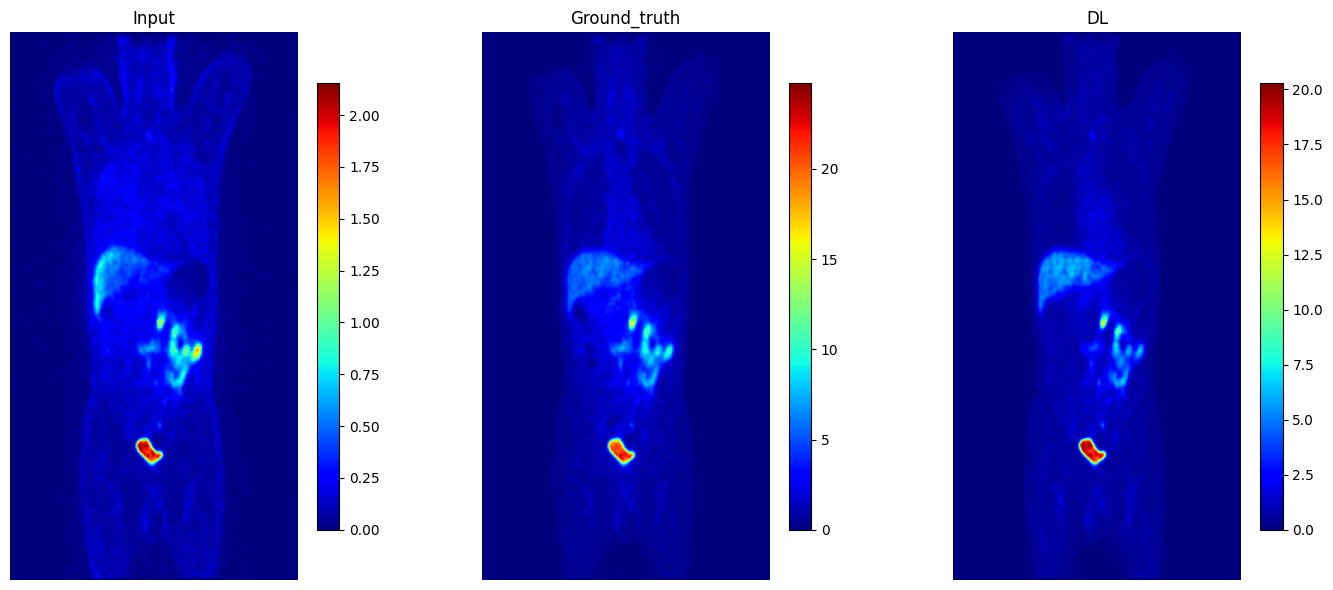

100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


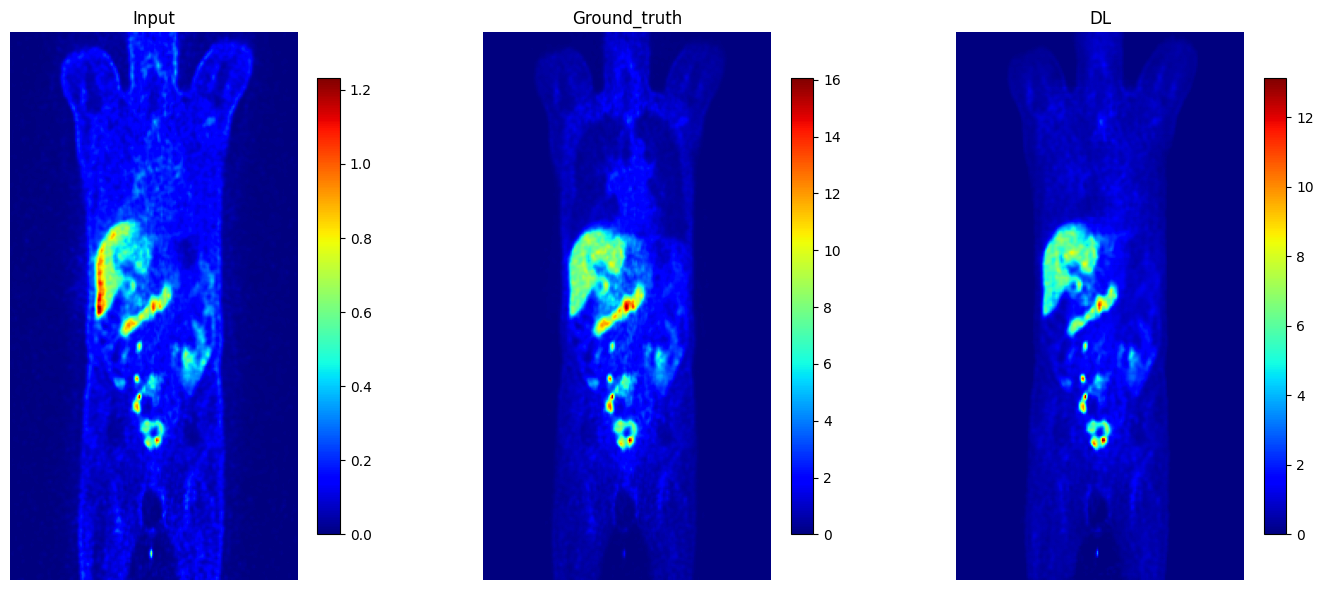

100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


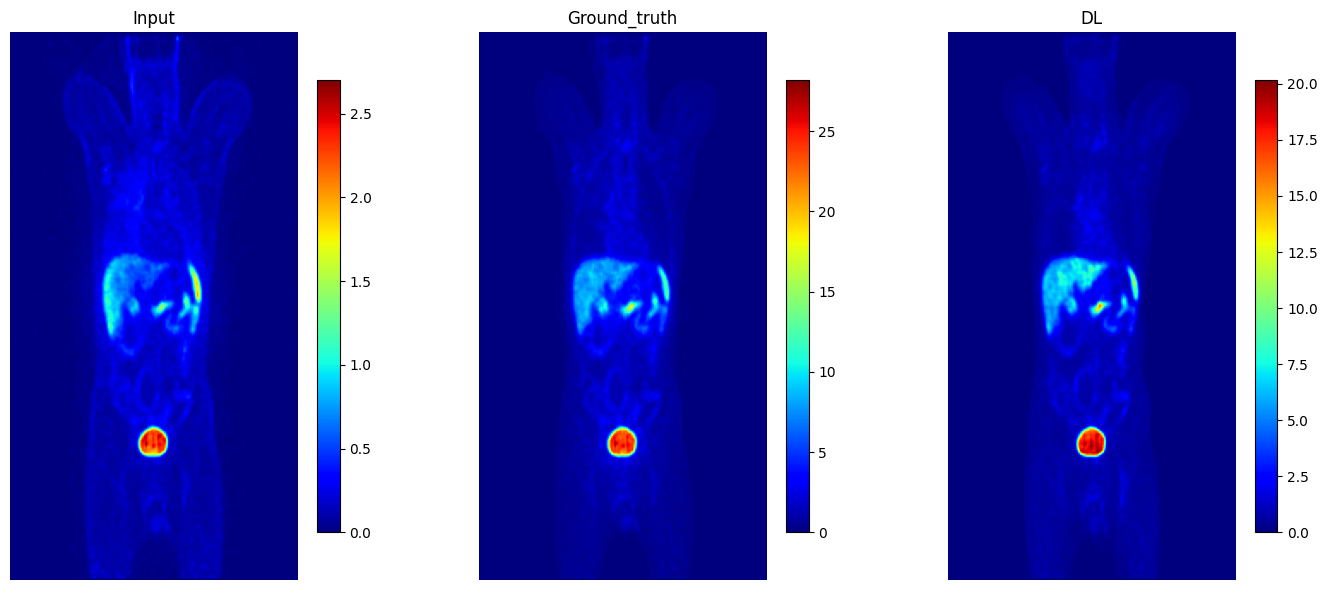

100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


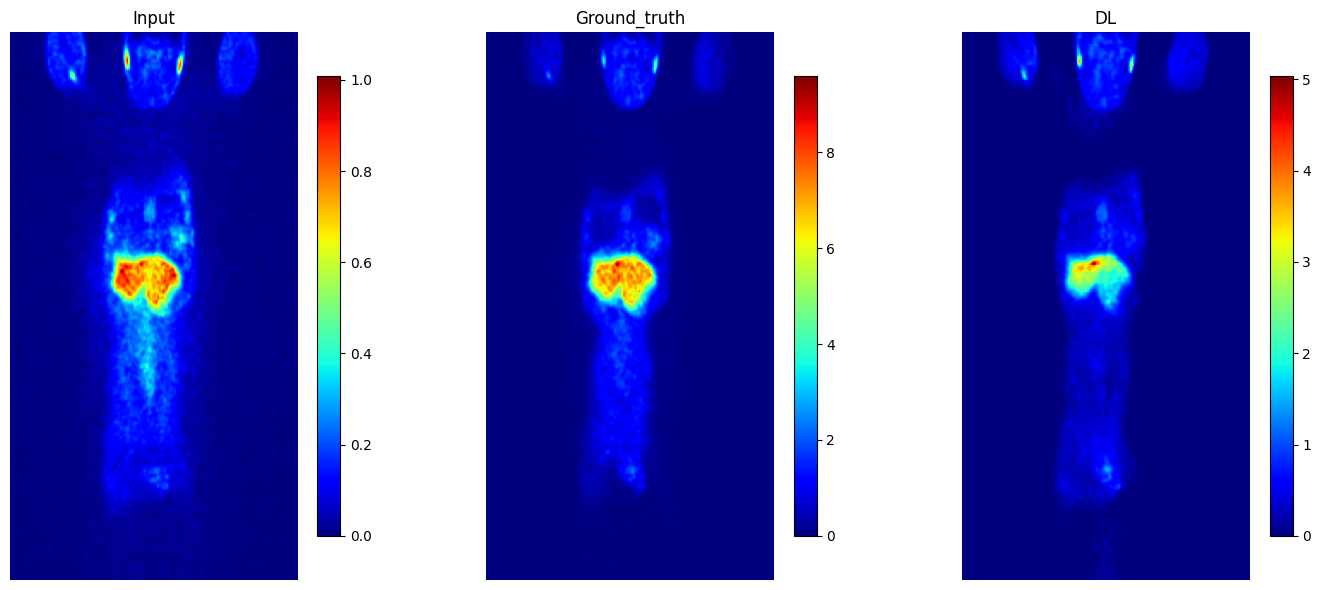

100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


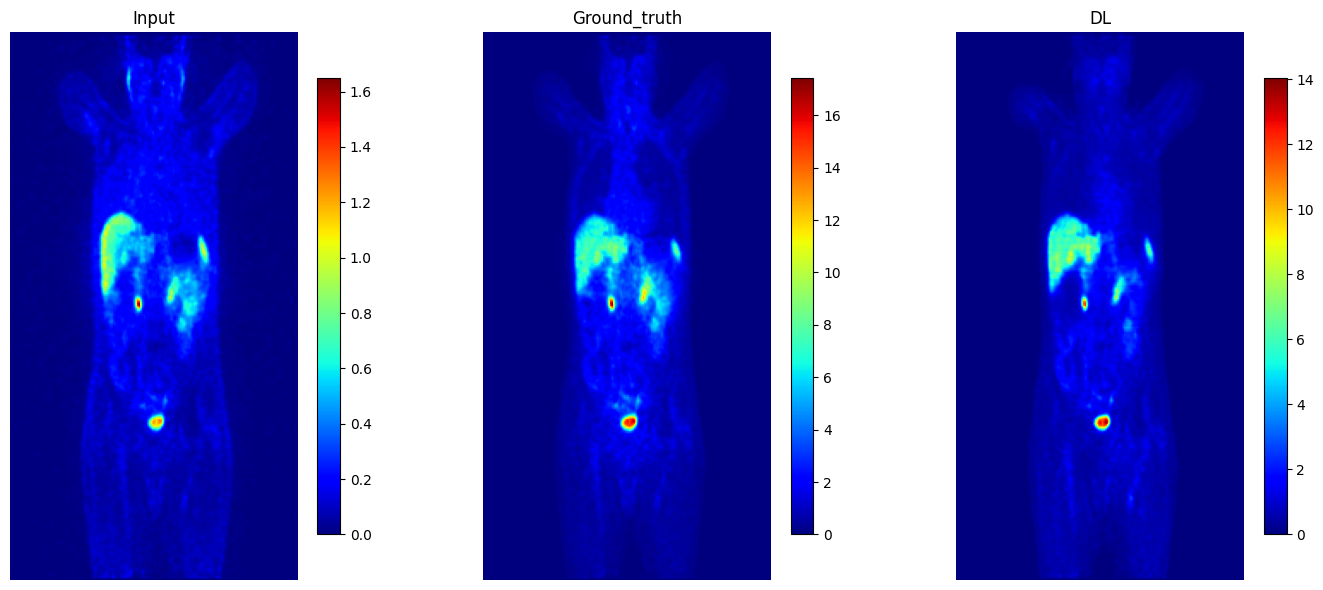

100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


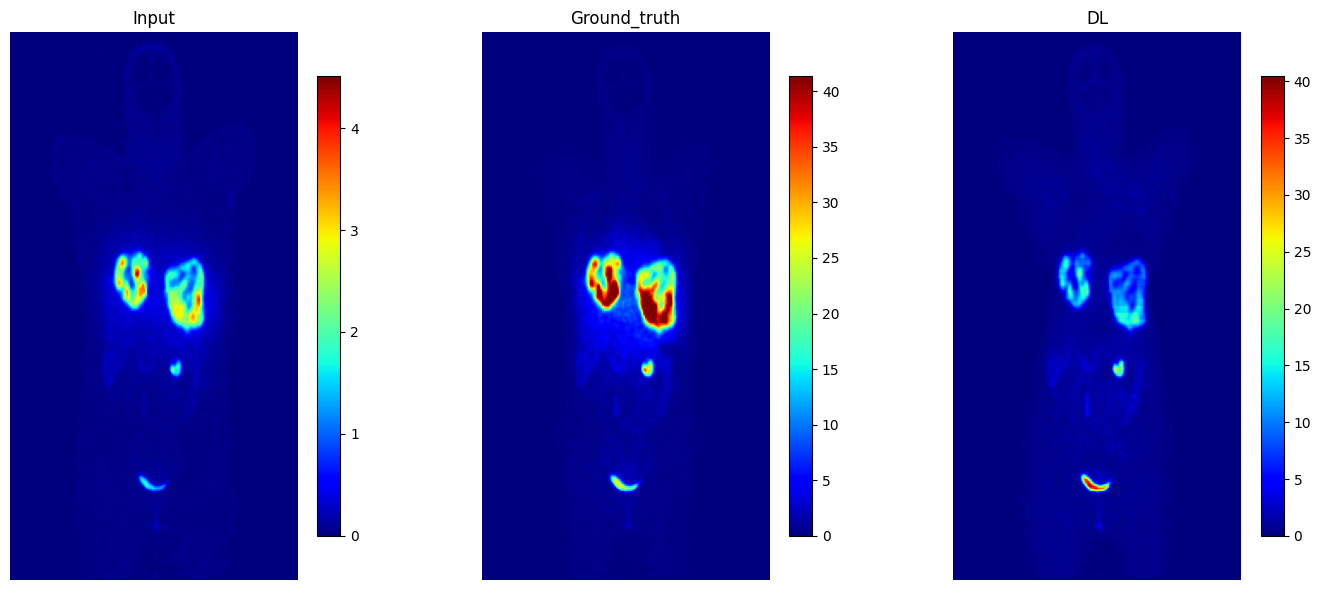

100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


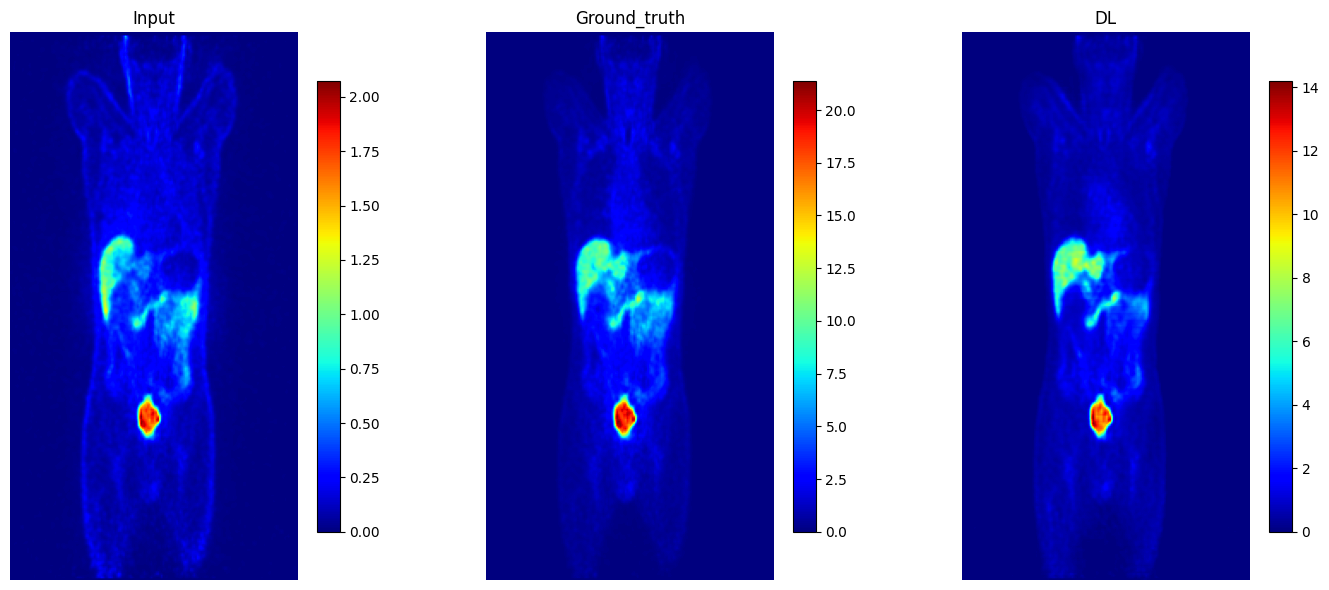

100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


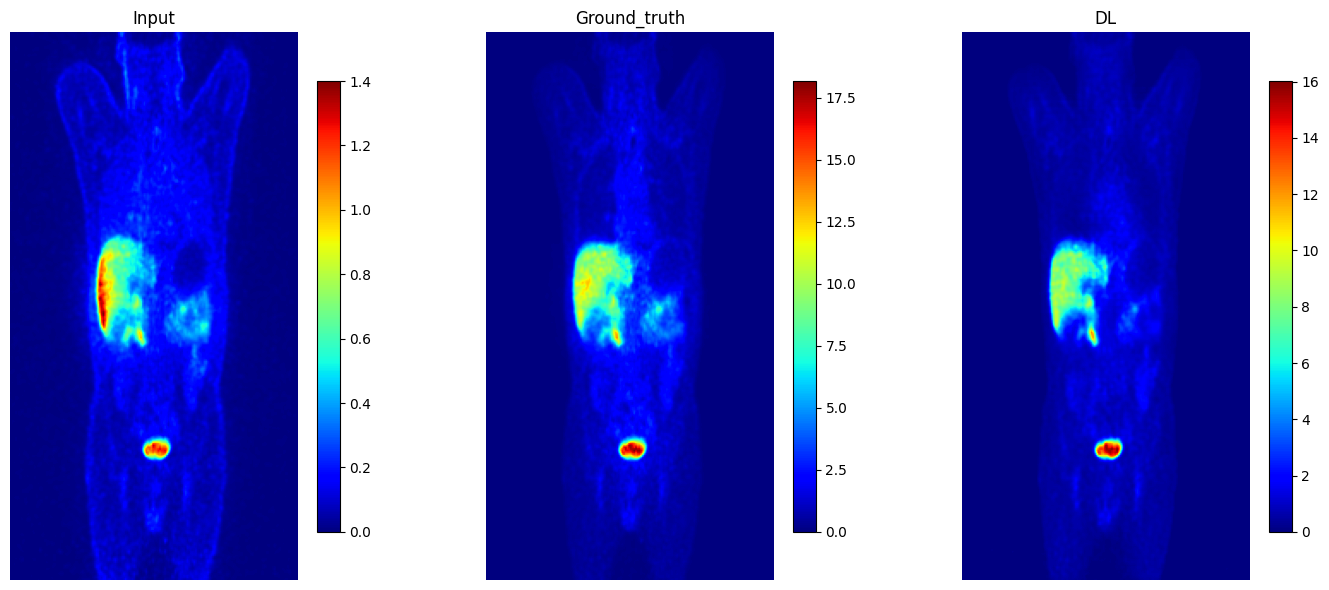

100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


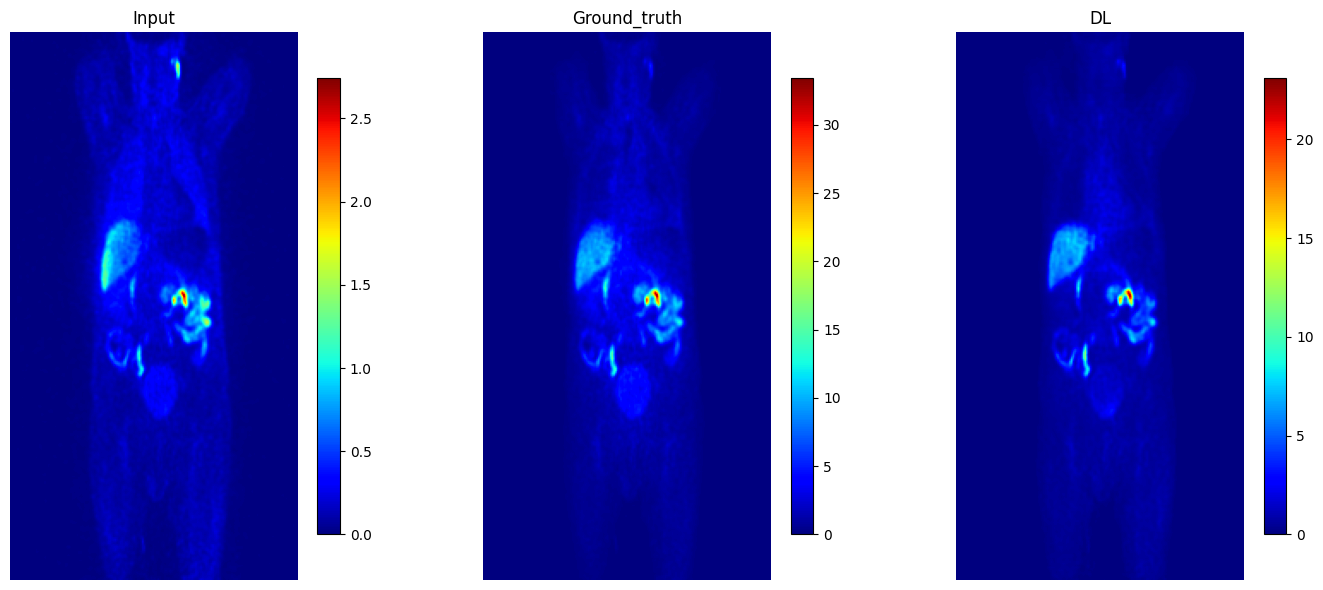

100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


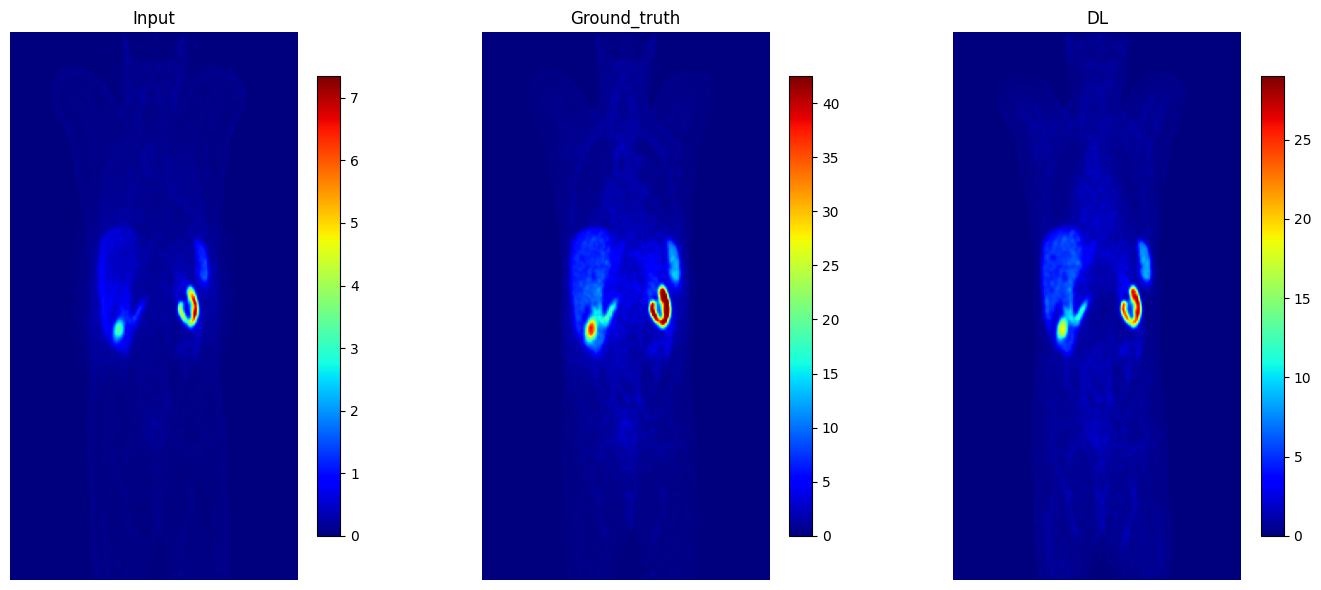

In [14]:
roi_size = (168, 168, 16)
sw_batch_size = 64
slice_number = 85

with torch.no_grad():
    for i, data in enumerate(test_loader):

        predict = sliding_window_inference(data["image"].to(config.device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70)
        
        model_visualize_coronal(data, predict, slice_number, 
                                f"DL", 
                                "jet", Norm=False)
        if i == 10:
            break


## Exporting DL image
**Uncomment below script, if you want to export the DL images as nifti output.**

In [ ]:
# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=loader_factory.get_test_transforms(),
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=config.ga_output_dir, output_postfix="comb_4_5_onfdg", resample=False), 
#     ]
# )

# with torch.no_grad():
#     for test_data in test_loader:
#         test_inputs = test_data["image"].to(config.device)
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.90)
#         post_processed = [post_transforms(i) for i in decollate_batch(test_data)]
